(320, 320, 3)


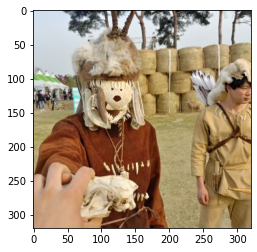

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

img_path = os.getenv('HOME')+'/aiffel/DaepyonimT_T/images/my_image.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [2]:
model_dir = os.getenv('HOME')+'/aiffel/DaepyonimT_T/models' 

model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/DaepyonimT_T/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fb4ab18bcd0>)

In [3]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)
segvalues, output = model.segmentAsPascalvoc(img_path)

In [4]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

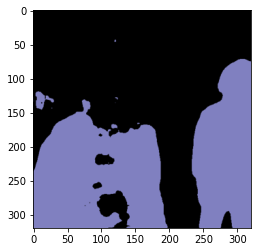

In [5]:
plt.imshow(output)
plt.show()

In [6]:
segvalues 

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])}

In [7]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [8]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [9]:
colormap[15]

array([192, 128, 128])

In [10]:
#colormap은 RGB 순서이나, output 이미지가 BGR 순서로 채널 배치가 되어 있음
seg_color = (128,128,192)

(320, 320)


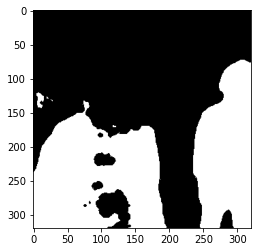

In [11]:
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

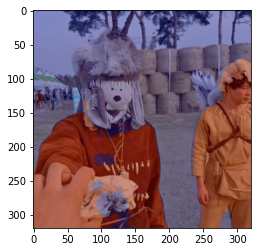

In [12]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

img_mask = seg_map.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

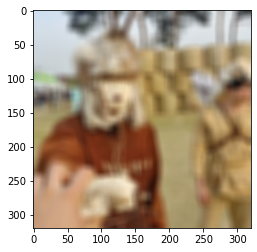

In [13]:
img_orig_blur = cv2.blur(img_orig, (13,13))

# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

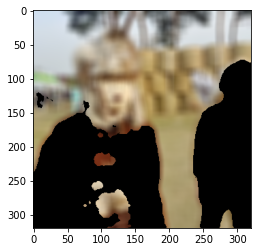

In [14]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 된다. 결국 사람이 사라지고 배경만 남는다.
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

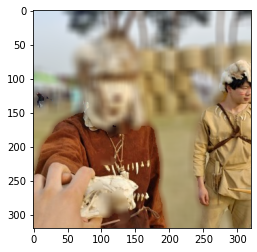

In [15]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

대안 제시

In [16]:
# - 해당 이미지는 가면이나 활, 뼈 등을 포함해 사람 외의 것들을 모두 배경으로 인식한다.
# - 해당 이미지에서 인물은 가면을 쓰고 있어 얼굴이 blur 처리되는 문제가 있다.
# - 이에 이미지 자체가 분류 문제 해결에 있어 좋은 이미지라 사료되지 않는다.
# - 이에 같은 이미지를 같은 각도에서 같은 채도, 명도로 찍어 분류 문제에 넣고자 한다면, 기존의 라벨 기준의 분류보다는 아웃포커싱과 보다
# 직접적으로 관련된 depth map을 이용해 deep learning을 수행하는 것이 옳다고 보인다.
# - depth map을 활용하기에 앞서 양안 카메라, 즉 stereo camera가 필요하다.

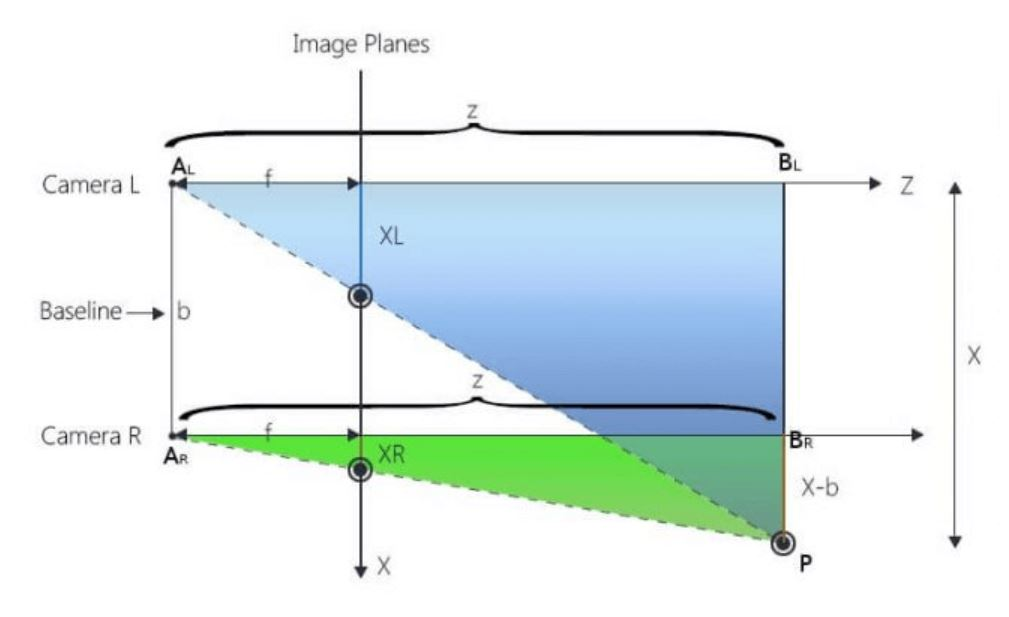

In [17]:
# - 스테레오 비전 카메라는 삼각 측량을 사용하여 깊이를 인식한다.
# - calibration을 이용해 disparity를 구하고 이로부터 거리를 측정한다.
# - deep learning을 수행하기 위해 양안에 cnn과 relu의 여러 층을 쌓아 feature를 학습하고
# 이 두 영상을 연쇄 또는 dot product를 하여 묶고, fully connected layer들과 sigmoid로
# smilarity score 를 구하여 학습한다.

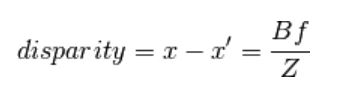

In [18]:
# - x와 x’는 장면 3D 포인트(X)가 이미지 평면에 표시되는 위치와 이를 촬영한 카메라의 중심 사이의 거리이고,
# - B는 두 카메라 사이의 거리이며 f는 카메라의 초점거리이다.
# - 포인트의 깊이는 이미지 포인트와 이를 촬영한 카메라 중심 사이의 거리 차이에 반비례한 것을 알 수 있으며,
# - 이를 통해 이미지에서 모든 픽셀의 깊이를 추출해낼 수 있다.

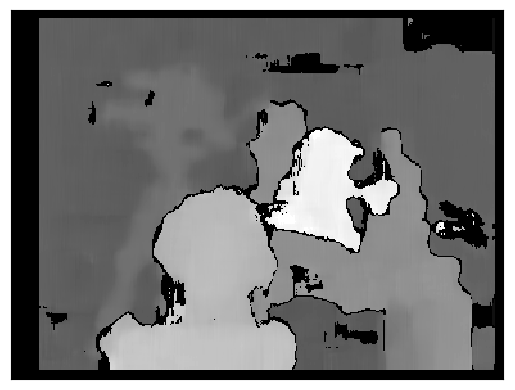

In [19]:
# - 카메라로부터 가까운 픽셀은 밝고, 멀어질 수록 어둡게 표시
# - 깊이에 따라 이미지의 blur를 달리하면 멀어질 수록 흐릿해지는 shallow focus가 가능하다.

In [ ]:
# 회고
# - 이번 프로젝트에서 어려웠던 점
# : 시험한 이미지에 대한 개선안을 알기 위해 depth map 등 기존에 알지 못했던 분야를 깊이 들어가 보아야 했다.
# - 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
# : 3d 카메라란게 있는 걸 처음 알았다 ㄷㄷ.. 조사를 하며 여러 사례를 통해 shallow focus는 물론 해상도가 개선된느 효과까지 확인하였지만,
# stereo camera를 통한 depth map 인식이 해당 사진에 어떻게 적용되고 결과물은 어떻게 나올 지는 모르겠다.
# - 루브릭 평가 지표를 맞추기 위해 시도한 것들:
# : 평가 기준에 제시된 내용에 맞추어 설명된 내용을 각각 순서대로 적용시켰다.
# - 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정:
# : 달성했다.
# - 자기 다짐:
# : 오늘도 잔다고 못낼 것 같아 새벽에 미리 적는다.... ex3 못낸게 너무 아쉽다.